In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Specie_finder_5C.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Specie_finder_5C/char/istockphoto (10)bright.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (10)Channel.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (10)grey.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (10)Hflip.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (10)Rot.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (10)Vflip.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)0.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)1.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)bright.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)Channel.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)grey.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)Hflip.jpg  
  inflating: /content/Specie_finder_5C/char/istockphoto (12)Rot.jpg  
  inflating: /content

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder="/content/Specie_finder_5C/"
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8, 0.1, 0.1))

Copying files: 5470 files [00:08, 664.22 files/s]


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/output/train/'
valid_path = '/content/output/val/'
test_path = '/content/output/test/'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg =VGG16 (input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/output/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
import keras
model.compile(
  loss='categorical_crossentropy',
  #optimizer='adam',
  optimizer = keras.optimizers.Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4375 images belonging to 5 classes.


In [ ]:
val_set = valid_datagen.flow_from_directory('/content/output/val/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 545 images belonging to 5 classes.


In [ ]:
test_set = valid_datagen.flow_from_directory('/content/output/test/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 550 images belonging to 5 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

<ipython-input-21-e65c131114f8>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
137/137 [==============================] - 195s 1s/step - loss: 3.5740 - accuracy: 0.7470 - val_loss: 0.8655 - val_accuracy: 0.8587
Epoch 2/5
137/137 [==============================] - 180s 1s/step - loss: 0.5362 - accuracy: 0.9191 - val_loss: 0.6120 - val_accuracy: 0.9046
Epoch 3/5
137/137 [==============================] - 180s 1s/step - loss: 0.4064 - accuracy: 0.9403 - val_loss: 2.0871 - val_accuracy: 0.8037
Epoch 4/5
137/137 [==============================] - 182s 1s/step - loss: 0.2599 - accuracy: 0.9591 - val_loss: 0.7482 - val_accuracy: 0.9248
Epoch 5/5
137/137 [==============================] - 184s 1s/step - loss: 0.5719 - accuracy: 0.9394 - val_loss: 1.4359 - val_accuracy: 0.8862


In [ ]:
val_set.class_indices

{'char': 0, 'perch': 1, 'pikePerch': 2, 'tilapia': 3, 'trout': 4}

**Evaluating the model**

In [ ]:
import matplotlib.pyplot as plt

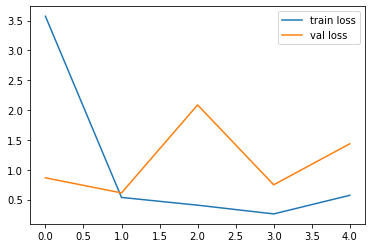

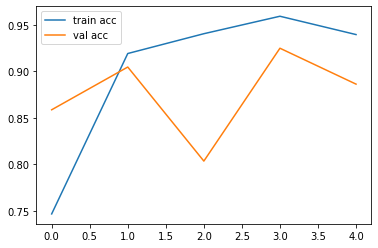

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

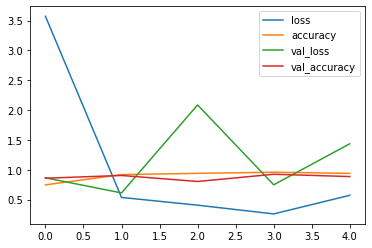

In [ ]:
import pandas as pd

pd.DataFrame(model.history.history).plot()

In [ ]:
y_pred = model.predict(test_set, verbose=1)

18/18 [==============================] - 25s 1s/step


In [ ]:
test_set.class_indices

{'char': 0, 'perch': 1, 'pikePerch': 2, 'tilapia': 3, 'trout': 4}

In [ ]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

18/18 [==============================] - 20s 1s/step - loss: 1.5030 - accuracy: 0.8982
The testing accuracy is : 89.81817960739136 %


In [ ]:
preds = model.predict(test_set,verbose=1)

21/21 [==============================] - 29s 1s/step


In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('specie_clss_vgg16.h5')